<a href="https://colab.research.google.com/github/Q-shick/amazon_food_review_nlp/blob/master/amazon_food_review_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Reviews Analysis
### *By Kyoosik Kim*
"Amazon Food Reviews" is a public dataset gathered from 1999 to 2012. Over 568K reviews are composed with 100 words with a short summary, also a score tagged for each reivew. The scores have five levels, 5 being the highest. Analyzing the text data with scores labeled, we can find trends between the reviews and the consumer experiences, based on which we can also build a model. The advantage of the model is being able to quantify reviews that future consumers would leave through any type of platform. That is, the model should be capable of a scoring system as long as any texts are given because the learning is made through a large amount of words and sentences.

<br>

The project will start with data setup in SQL format in which we will focus on review and score columns. Before analyzing, we will validate the completeness of the dataset by checking any missing cells, data types, etc. For the first analysis, we will focus on the scores to see how good reviews are distributied and vise versa. This section is mainly examining the groups to find statistical differences. Then, we will carry out topic decompositions using LDA and NMF to get some ideas what the texts are about. Next, we will analyze sentiments of reviews by each score group. Based on the analysis, we will build a baseline model based on 'bag of words' concept. Finally, we will build a sophiscated model such a deep learning model using the Keras framework.
<br>

1.   Load the Dataset
2.   Data Cleansing Check-up
3.   Statistical Analysis
4.   Topic Analysis
5.   Sentiment Analysis
6.   Named Entity Recognition
7.   Baseline Model
8.   Deep Learning Model
9.   Model Tuning and Evaluation
10. Multiple Input MLP Model
11. Conclusion and References

*Environment*: Google Colab (Tesla 80K GPU)
<br>
*Keywords*: 

## 1. Load Dataset
The dataset is stored in *Google Drive* and downloadable via the *PyDrive* API. This is faster than uploading from a local drive and a better way in accessibility and robustness. But it requires an authentification process. The format is *SQLite* in which we can query the data we need such as reviews and scores. We will also query the feature called "Helpfulness" which indicates how people agree with each review. There are duplicate products, meaning that one product is most likely to have multiple reviews. The feature helpfulness allows us to filter only useful reviews. In other words, we can leave out reviews that people do not agree with. For example, a product with good reviews overall could have a couple of bad reviews. These bad reviews are likely to have high ratio of disagree over agree such as 1 upvote vs. 10 downvotes. We may utilize this ratio to evaluate each review.

In [0]:
# Install the PyDrive wrapper & import libraries
# This only needs to be done once per notebook
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
# This only needs to be done once per notebook
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID
file_id = '1g7jG4xIB1F12hfd2Xw6TD4xaeEs5xr1p'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('reviews.sqlite')

In [0]:
# basic libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [4]:
# query dataset
import sqlite3

conn = sqlite3.connect('/content/reviews.sqlite')
c = conn.cursor()

read_query = "SELECT HelpfulnessNumerator, HelpfulnessDenominator, \
                     Score, Summary, Text \
              FROM Reviews"
df = pd.read_sql_query(read_query, conn)
print("Data frame (row x col):", df.shape)

Data frame (row x col): (568454, 5)


In [5]:
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,0,0,5,Great taffy,Great taffy at a great price. There was a wid...


As explained, "Helpfulness Numerator" is how may users agreed with the review (upvote) while "Helpfulness Denominator" is how many users responded (total). Then, the difference between the two becomes how many users disagreed (downvote). We now can set a rule to eliminate reviews of which the downvote ratio is equal to or above 50%.

In [6]:
helpful = ['HelpfulnessNumerator', 'HelpfulnessDenominator']

# helpful votes must be smaller than total
df = df[ df[helpful[0]] <= df[helpful[1]] ]

unreliable_reviews = []
for i, num, deno in df[helpful].itertuples():
  if deno != 0:
    if (deno-num)/deno >= 0.5:
      unreliable_reviews.append(i)

df.drop(index=unreliable_reviews, inplace=True)
# df.drop(columns=helpful, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Unreliable reviews (50% or above downvoted):", len(unreliable_reviews))
print("Data frame (row x col):", df.shape)

Unreliable reviews (50% or above downvoted): 71736
Data frame (row x col): (496716, 5)


## 2. Data Cleansing Check-up
Text data is tricky in that the way a computer understands is different from the way we do. A blank is a perfect example. When there is only a space, we don't see anything but a computer still accepts it as a character. Also, there could be some format issues like *HTML* as the reviews were extracted from a website. Although the dataset is thought to be processed to some degree, it would be still a good idea to make sure of the issues aforementioned.

In [7]:
df.isnull().sum()

HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Summary                   0
Text                      0
dtype: int64

In [8]:
non_str = []
space_str = []

for i, smry, text in df[['Summary', 'Text']].itertuples():
  if not (type(smry)==str and type(text)==str):
    non_str.append(i)
  else:
    if (smry.isspace() or text.isspace()):
      space_str.append(i)
        
print("Non String:", non_str, "\nBlank:", space_str)

Non String: [] 
Blank: []


Now that we have confirmed there isn't any null or blank, we can safely read some random sentences. However, there is a lurking problem in some sentences like below that there are *HTML* tags. As mentioned, these are data that users typed on a website environment. This can be handled with *BeautifulSoup* library which is capable of recognizing the tags. We will remove all the tags to extract only texts.

In [9]:
print(df.iloc[21280]['Text'])

CAUTION...DO NOT use ice cubes in any Zevia soda.<br />I am hooked on Zevia sodas because their tastes are not "heavy." Each flavored soda seems to have just the right amount of taste. Once you add ice, the taste seems to get watered down.<br />Zevia is my new soda of choice.


In [10]:
%%time

from bs4 import BeautifulSoup

df['Text'] = df['Text'].apply(lambda x: BeautifulSoup(x).get_text())
print(df.iloc[21280]['Text'])

CAUTION...DO NOT use ice cubes in any Zevia soda.I am hooked on Zevia sodas because their tastes are not "heavy." Each flavored soda seems to have just the right amount of taste. Once you add ice, the taste seems to get watered down.Zevia is my new soda of choice.
CPU times: user 2min 21s, sys: 4.09 s, total: 2min 25s
Wall time: 2min 26s


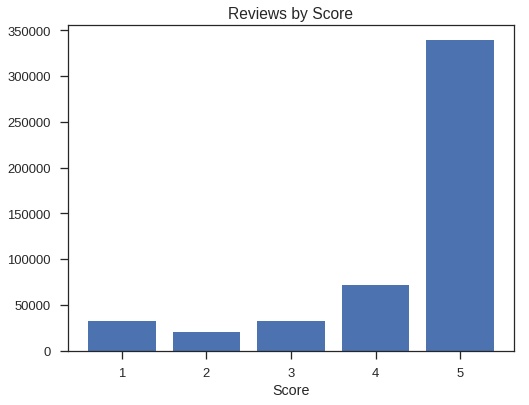

In [11]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1,6), np.bincount(df['Score'])[1:])
plt.title("Reviews by Score")
plt.xlabel("Score")
plt.show()

The distribution of the score 1~5 is quite skewed. Obviously, the users were satisfied by giving mostly 5 for the score. What to remember here is that our goal is to investigate how reviews are linked with scores. This means that the Amazon reviews may look like the plot above but not necessarily somewhere else. Namely, our goal is to investigate general patterns of food reviews. Thus, we will draw samples equally from each score group for analysis and eventually for modeling as well.

## 3. Statistical Analysis
First, we want to ensure whether the score groups are significantly different from each other. Because our main focus is the review feature, we can apply statistical methods to some characteristics of the feature such as word count or even a sophisticated property like *part-of-speech*. This will be done with help of the NLP library *spacy* which handles text data as documents that can be tokenized and decomposed thoroughly.

In [12]:
import spacy
!python -m spacy download en_core_web_lg # if not installed
nlp = spacy.load('en_core_web_lg') # about 850 MB
from spacy import displacy

    100% |████████████████████████████████| 852.3MB 30.3MB/s 
  Running setup.py install for en-core-web-lg ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_lg -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



In [0]:
np.random.seed(2019)

"""
Pool equal 'n' samples by group without replacement
Return indice of samples
"""
def random_pooling(df, sample_len, classes=np.arange(1,6)):
  scores = [np.random.choice(df[df['Score']==x].index, sample_len, replace=False)
            for x in classes]
  
  return np.array(scores)

In [14]:
scores = random_pooling(df, 400)

example_reviews = df.head(0)
for i in range(5):
  example_reviews = pd.concat([example_reviews, df.iloc[scores[i]][:5]])
  
example_reviews

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text
153349,10,11,1,"Mostly overpriced filler, little tenderizer",Very little tenderizer in the tenderizer.Read ...
417638,1,1,1,DO NOT BUY THESE - THEY CAN KILL YOUR PET,Absolutely DO NOT BUY these bones! I bought a ...
369476,7,8,1,Made in China,Why gamble with your dog's health? These are m...
466084,4,4,1,Disappointing,"I was very happy with the just strawberries, a..."
86390,1,1,1,Product has changed for the worse over the pas...,"I have been buying Blue Dog Bakery, Peanut But..."
366331,0,0,2,not impressed,Have to say that I dont get much effect out of...
17482,1,1,2,Too sweet,I made this this past weekend and I am not a f...
312549,0,0,2,Not the type grandma made,"This would be better called by pickles, since ..."
403563,2,2,2,"Dented cans, tinny taste",I bought a case of both the Native Forest Orga...
454300,0,0,2,Way too salty to enjoy,"Having had plantain chips before, I knew them ..."


From both the summary and review, we can easily figure out how these are matched to the scores. But there could be some reviews which signals the opposite to the NLP process. Especially, reviews with lower scores might have positive words like 'Good', 'Like', 'Great', but these could be simply sarcasm. We will look into this issue later in the sentiment analysis section.

In [15]:
"""
Count adjetive and adverb
Scale them to per 100 words
Return a list of lists by score group)
"""
def expressiveness(i):
  adj_adv = []
  tokens = []
  
  for sentence in df.iloc[scores[i]]['Text']:
    doc = nlp(sentence)
    expr_count = 0
    for token in doc:
      if token.pos_=='ADJ' or token.pos_=='ADV':
        expr_count += 1
    # adjective and adverb per 100 words
    adj_adv.append(expr_count*100/len(doc))
    tokens.append(len(doc))
    
  return np.array(adj_adv), np.array(tokens)
  
%time expr_scores = [expressiveness(x) for x in range(5)]

CPU times: user 2min 23s, sys: 51.1 s, total: 3min 15s
Wall time: 1min 43s


In [16]:
adj_adv_average = [round(adj_adv[0].mean(), 1) for adj_adv in expr_scores]
length_average = [round(adj_adv[1].mean(), 1) for adj_adv in expr_scores]

pd.DataFrame({'ADJ/ADV_per_100': adj_adv_average,
              'Sentence_Length': length_average}, index=np.arange(1,6))

,ADJ/ADV_per_100,Sentence_Length
1,16.9,102.9
2,18.0,101.7
3,18.5,117.0
4,18.1,106.1
5,18.2,83.4


It is quite clear that users with score 1 and 2 didn't use as many adjectives and adverbs as the others. But they wrote as long sentences as the other except for the score 5. It is interesting that users with score 5 used many adjectives and adverbs but wrote the shortest. Another to note is that users with score 3 were most expressive as well as most lengthy. They were neutrally satisfied and seemingly tried to give some practical feedbacks, not just describing their feelings, as we briefly saw above.

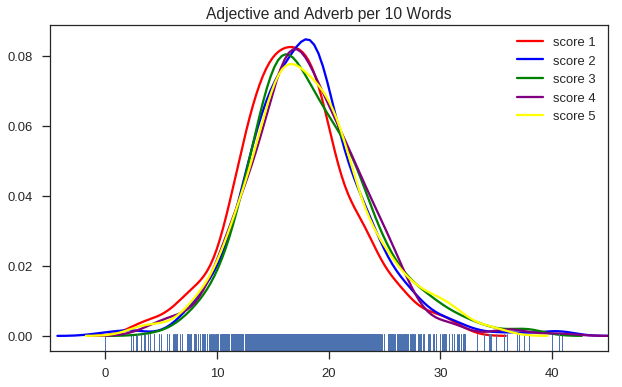

In [17]:
plt.figure(figsize=(10,6))

colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['score 1', 'score 2', 'score 3', 'score 4', 'score 5']
for i in range(5):
  sns.kdeplot(expr_scores[i][0], color=colors[i], label=labels[i])
  sns.rugplot(expr_scores[i][0])

plt.title("Adjective and Adverb per 10 Words")
plt.xlim(-5, 45)
plt.legend()
plt.show()

In [18]:
import scipy.stats as stats

print("Shapiro's Normality Test\n")
for i in range(5):
  _, p = stats.shapiro(expr_scores[i][0])
  print("- Score {}'s P-value: {:.3f}".format(i+1, p))

Shapiro's Normality Test

- Score 1's P-value: 0.032
- Score 2's P-value: 0.000
- Score 3's P-value: 0.000
- Score 4's P-value: 0.000
- Score 5's P-value: 0.002


The 5 groups all look like a bell shape, but we still want to make sure of normality by using *Shapiro's Test*. According to the test, they are all normal, letting us conduct another statistical test *ANOVA*. As seen below, the ANOVA test shows that only the score 1 is different from the rest in how many adjectives and adverbs are used. Indeed, the score 1 (red) on the plot is slightly on the left.

In [19]:
print("ANOVA Test between Scores\n")
print("- Score 1 vs 2: ", stats.kruskal(expr_scores[0][0],
                                       expr_scores[1][0]).pvalue.round(3))
print("- Score 2 vs 3 vs 4 vs 5: ", stats.kruskal(expr_scores[1][0],
                                       expr_scores[2][0],
                                       expr_scores[3][0],
                                       expr_scores[4][0]).pvalue.round(3))

ANOVA Test between Scores

- Score 1 vs 2:  0.004
- Score 2 vs 3 vs 4 vs 5:  0.806


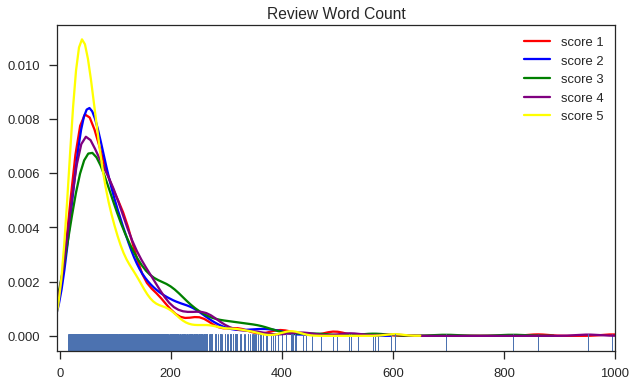

In [20]:
plt.figure(figsize=(10,6))

colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['score 1', 'score 2', 'score 3', 'score 4', 'score 5']
for i in range(5):
  sns.kdeplot(expr_scores[i][1], color=colors[i], label=labels[i])
  sns.rugplot(expr_scores[i][1])

plt.title("Review Word Count")
plt.xlim(-5, 1000)
plt.legend()
plt.show()

In [21]:
percentile_idx = np.array(expr_scores)[:,1].flatten()

print("Words at percentile 90 / 95 / 97.5 / 99:",
      np.percentile(percentile_idx, [90, 95, 97.5, 99]).round(0))

Words at percentile 90 / 95 / 97.5 / 99: [207. 265. 340. 438.]


In fact, the longest review is over 4000 words not even drawn on the plot. The word counts are skewed with most of them centered on the shorter side. About 100 words are the average of them. Since they are not normal or in similar shape, we may not conduct a statistical test, although there are still some available tests. Instead, we like to focus on cutting off the long tail, the outliers. This can be done either by tokenizing or simply splitting sentences. The former should use *spacy* library and the letter can use the build-in function. The result might be different but not significantly.

In [22]:
print("Time elapsed for Spacy nlp processing")
%time t1 = df['Text'][:100].apply(lambda x: True if len(nlp(x))<=300 else False)

print("\nTime elapsed for Python built-in split processing")
%time t2 = df['Text'][:100].apply(lambda x: True if len(x.split(' '))<=300 else False)

Time elapsed for Spacy nlp processing
CPU times: user 6.03 s, sys: 2.28 s, total: 8.31 s
Wall time: 4.26 s

Time elapsed for Python built-in split processing
CPU times: user 1.85 ms, sys: 1.17 ms, total: 3.02 ms
Wall time: 1.55 ms


In [23]:
rows_before = df.shape[0]

# throw rows with over 300 words
df = df[df['Text'].apply(lambda x: True if len(x.split(' '))<=280
                         else False)]
df.reset_index(drop=True, inplace=True)
rows_after = df.shape[0]

# check the result
print("Data size change:", round(rows_after/rows_before, 3), '%')

Data size change: 0.975 %


## 4. Topic Analysis
Decomposition techniques such as *Latent Dirichlet Allocation* or *Non-negative Matrix Factorization* are good at extracting topics. Both fall in unsupervised learning category, therefore, it may not directly help us build a model. Nonetheless, the topic analysis is helpful to understand what contents we are dealing with. We will group the reviews into 10 topics.

In [0]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [0]:
def lda_extract(size, score, num_topic):
  indice = df[df['Score']==score].index
  sentences = df.iloc[np.random.choice(indice, size, replace=False)]['Text']

  vectorizer = CountVectorizer(max_df=.95, min_df=10, stop_words='english')
  topic_sentences = vectorizer.fit_transform(sentences)

  LDA = LatentDirichletAllocation(n_components=num_topic)
  LDA.fit(topic_sentences)
  
  print("- Score ", score, " Topics")
  for i, topic in enumerate(LDA.components_):
    print(i+1, ":", [vectorizer.get_feature_names()[j] for j 
          in topic.argsort()[-10:]])
  print('\n')

In [26]:
for i in np.arange(1,6):
  lda_extract(2000, i, 5)

- Score  1  Topics
1 : ['like', 'price', 'bag', 'ordered', 'order', 'item', 'box', 'product', 'amazon', 'tea']
2 : ['cans', 'time', 'buy', 'cat', 'cats', 'amazon', 'product', 'eat', 'like', 'food']
3 : ['bought', 'buy', 'food', 'just', 'product', 'china', 'jerky', 'dogs', 'treats', 'dog']
4 : ['tastes', 'cup', 'bad', 'good', 'tried', 'just', 'flavor', 'coffee', 'taste', 'like']
5 : ['bottle', 'amazon', 'like', 'taste', 'package', 'just', 'ingredients', 'oil', 'sugar', 'product']


- Score  2  Topics
1 : ['tasted', 'better', 'chocolate', 'try', 'really', 'good', 'flavor', 'like', 'just', 'taste']
2 : ['texture', 'juice', 'flavor', 'bars', 'good', 'don', 'sugar', 'taste', 'like', 'product']
3 : ['received', 'got', 'bought', 'store', 'time', 'order', 'price', 'amazon', 'box', 'product']
4 : ['taste', 'just', 'treats', 'eat', 'don', 'really', 'product', 'food', 'like', 'dog']
5 : ['drink', 'water', 'just', 'good', 'cup', 'flavor', 'taste', 'like', 'tea', 'coffee']


- Score  3  Topics
1 : 

The topics are staples like sugar and milk, pets, sweets, drinks like coffee and tea, price, and taste and flavor. These are all relevant with foods and the words in each topic are also related somehow.

In [0]:
def nmf_extract(size, score, num_topic):
  indice = df[df['Score']==score].index
  sentences = df.iloc[np.random.choice(indice, size, replace=False)]['Text']

  vectorizer = CountVectorizer(max_df=.95, min_df=10, stop_words='english')
  topic_sentences = vectorizer.fit_transform(sentences)

  nmf = NMF(n_components=num_topic)
  nmf.fit(topic_sentences)
  
  print("- Score ", score, " Topics")
  for i, topic in enumerate(nmf.components_):
    print(i+1, ":", [vectorizer.get_feature_names()[j] for j 
          in topic.argsort()[-10:]])
  print('\n')

In [28]:
for i in np.arange(1,6):
  nmf_extract(2000, i, 5)

- Score  1  Topics
1 : ['bad', 'tried', 'really', 'tastes', 'good', 'don', 'flavor', 'just', 'taste', 'like']
2 : ['did', 'box', 'buy', 'don', 'order', 'received', 'products', 'ordered', 'amazon', 'product']
3 : ['picture', 've', 'bag', 'bags', 'stash', 'box', 'teas', 'organic', 'green', 'tea']
4 : ['cats', 'eat', 'vet', 'pet', 'just', 'cat', 'dogs', 'treats', 'dog', 'food']
5 : ['tried', 'keurig', 'pack', 'coffees', 'hazelnut', 'cups', 'flavored', 'flavor', 'cup', 'coffee']


- Score  2  Topics
1 : ['love', 'did', 'didn', 'try', 'tastes', 'don', 'just', 'really', 'flavor', 'like']
2 : ['beans', 'flavor', 'roast', 'good', 'strong', 'bitter', 'weak', 'cups', 'cup', 'coffee']
3 : ['ginger', 'black', 'box', 'drink', 'bags', 'cup', 'green', 'flavor', 'water', 'tea']
4 : ['don', 'eat', 'really', 'time', 'dog', 'amazon', 'just', 'good', 'food', 'product']
5 : ['drink', 'tried', 'better', 'just', 'water', 'mix', 'sugar', 'chocolate', 'good', 'taste']


- Score  3  Topics
1 : ['sweet', 'just',

The result of *NMF* is very similar with *LDA* both in topics and the words in them. With the topics, we can say that what users are talking about is mostly items, taste, and prices. If there were topics like 'military' or 'politics', we may consider more research to remove them. But all topics look in our scope, thus, we don't need to remove any of them.

## 5. Sentiment Analysis
Every word in a sentence has a certain level of sentiment. Simply speaking, the word 'Good' is mostly related with a positive feeling while 'Bad' is negetive. However, the human language system isn't so simple that one word could have different meanings depending on a context. Also some words do not have any sentiment. What *NLTK* library we will be using only does overall word-by-word job to capture sentiments without understanding sentences in depth.

In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [0]:
sid = SentimentIntensityAnalyzer()

scores = random_pooling(df, 2000)
comp_scores = [df.iloc[scores[i]]['Text'].apply(lambda x:
               sid.polarity_scores(x)['compound']) for i in range(5)]

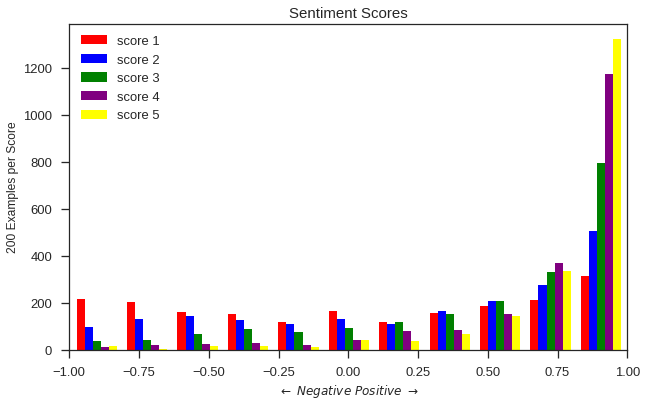

In [31]:
colors = ['red', 'blue', 'green', 'purple', 'yellow']
labels=['score 1', 'score 2', 'score 3', 'score 4', 'score 5']

plt.figure(figsize=(10,6))
plt.hist(comp_scores, bins=11, color=colors, label=labels)
plt.title("Sentiment Scores", fontsize=15)
plt.xlabel(r"$\leftarrow\ Negative\ Positive\ \rightarrow$", fontsize=12)
plt.ylabel("200 Examples per Score", fontsize=12)
plt.xlim(-1,1)
plt.legend()
plt.show()

From the left where sentiments are the most negative, the score 1 sentences are the most and the score 2, and so on. This pattern continues to over 0.00 where sentences are neutral. After then, the high scores start to surge and end up being the most at the most positive sentiments. Score 4 and 5 sentences are almost invisible until 0.50 but pop out largely after that point. Surprisingly, score 1 sentences used quite many positive words, however, this must be words like 'like' or '!' because *Vader* takes them as positive words.

In [32]:
pd.DataFrame({'label': df.iloc[np.array(scores).flatten()]['Score'],
              'compound': np.array(comp_scores).flatten()}).corr()

,compound,label
compound,1.000000,0.468456
label,0.468456,1.000000


The sentiments are 0.5 correlated with scores, which is more than moderate but not too high. This could be built into a model if it was higher. Still, we can consider using this as a feature in addition to the text feature. Knowing that, we should also keep in mind that there are sarcasm sentences like some examples as below.

In [33]:
score_1_good = comp_scores[0].apply(lambda x: x 
                              if x>0.8 else None).dropna().index

score_1_examples = list(df.iloc[score_1_good]['Text'])

pprint(score_1_examples[0])
print('\n')
pprint(score_1_examples[3])
print('\n')
pprint(score_1_examples[9])

("There was a piece of a different formula label underneath the Earth's Best "
 'Formula label!!  Even the bottom of the can had a different look than the '
 "Earth's Best Soy formula that is sold in the store.  We contacted the "
 'manufacturer about this issue and they have yet to respond.')


('First of all, I am aware that this is made for the gun, however after '
 'reading the reviews I purchased it and let me say I have never been more '
 'dissapointed. In the picture the gold is brilliant, bold, and intense. When '
 'I got this product it was oily in appearance and looked like vinegar in '
 'color. I used a paintbrush as I read in a previous review. The color is a '
 'yellow, maybe a copper tone---nothing like gold. I used part of this for an '
 'anniversary cake--I had to drive to the arts and crafts store to purchase '
 'Wiltons Gold shimmer to attempt to cover this disaster. I thought $15 was '
 'pretty expensive in the first place, but after using the product I am sure '
 'i

## 6. Named Entity Recognition
Our focus is analyzing general reviews on foods, not specific products or companies. This is to make the model applicable to any type of food reviews. For this, we need to eliminate named entities to purely focus on expressions. This can be done by *spacy* again with its capacity of identifying named entities. We have downloaded the large corpus which will recognize major products and companies, etc. This process could be unnecessary because these named entities would not show up in not that many reviews, meaning that they would be ignored anyway later in modeling. However, we can be sure of that not happening until we read all or most of the reviews. That's why this process is recommended.

In [34]:
from collections import Counter

df['Score'].value_counts()

min_len = len(df[df['Score']==2])

print("Before undersampling: classes -", Counter(df['Score']))
undersampling_idx = random_pooling(df, min_len)
df = df.iloc[np.array(undersampling_idx).flatten()]
df.reset_index(drop=True, inplace=True)
print("After undersampling: classes -", Counter(df['Score']))

Before undersampling: classes - Counter({5: 332420, 4: 69406, 3: 31487, 1: 30998, 2: 19994})
After undersampling: classes - Counter({1: 19994, 2: 19994, 3: 19994, 4: 19994, 5: 19994})


In [35]:
rand_idx = np.random.choice(df.index, 10)
entities_10_sentences = nlp(' '.join(df.iloc[rand_idx]['Text']))
displacy.render(entities_10_sentences, style='ent', jupyter=True)

In [36]:
rand_idx = np.random.choice(df.index, 100)
entities_100_sentences = nlp(' '.join(df.iloc[rand_idx]['Text']))
labels = [x.label_ for x in entities_100_sentences.ents]

print("Named Entities")
pprint(Counter(labels))

Named Entities
Counter({'CARDINAL': 79,
         'ORG': 70,
         'PERSON': 34,
         'DATE': 29,
         'ORDINAL': 18,
         'QUANTITY': 16,
         'NORP': 14,
         'TIME': 11,
         'MONEY': 11,
         'PRODUCT': 10,
         'GPE': 10,
         'FAC': 8,
         'WORK_OF_ART': 7,
         'EVENT': 2,
         'PERCENT': 1,
         'LAW': 1,
         'LOC': 1,
         'LANGUAGE': 1})


In [37]:
%%time

def remove_ner(sent):
  doc = nlp(sent)
  ner_idx = [(ent.start_char, ent.end_char) for ent in doc.ents]

  if ner_idx: # if not empty
    ner_removed = ""
    ner_len = len(ner_idx)-1
    
    ner_removed += sent[:ner_idx[0][0]]
    for i in range(ner_len):
      ner_removed += sent[ner_idx[i][1]+1 : ner_idx[i+1][0]]
    ner_removed += sent[ner_idx[ner_len][1]+1:]
    
    return ner_removed
    
  else:
    return sent
  
df['Text'] = df['Text'].apply(lambda x: remove_ner(x))

CPU times: user 1h 44min 24s, sys: 38min 55s, total: 2h 23min 19s
Wall time: 1h 12min 59s


The following code is to save the result we have made so far. Removing named entities is such a time consuming process we don't want to repeat too many times. Again, we can simply upload the file to Google Drive so we can download quickly.

In [0]:
# Save the cleaned file
df.to_csv('/content/amazon_food_review_processed.csv', header=True, index=False)

# Upload to Google Drive
uploaded = drive.CreateFile({'title': 'amazon_food_review_processed.csv'})
uploaded.SetContentFile('/content/amazon_food_review_processed.csv')
uploaded.Upload()

# Download the cleaned file
# file_id = '1M6fOcmUYya7RLza0QxN4UB0MZb1BtK-y'
# downloaded = drive.CreateFile({'id': file_id})
# downloaded.GetContentFile('amazon_food_review_processed.csv')

# df = pd.read_csv('amazon_food_review_processed.csv')

## 7. Baseline Model
Before building a deep learning model, we would like to have a baseline model. Logistic Regression is always a good choice for the start. The process won't be too different than we are already thinking about for a deep learning model. First, we need to split reviews into two groups; training set and testing set. Then, we should vectorize the bag of words so the machine can read them. That means there will be as many features as all the different words set throughout the reviews. However, most of the features will be zeros (sparse vectors) because each reivew is relatively so short compared with all words in the word index.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X = df['Text']
y = df['Score']

sentence_train, sentence_test, y_train, y_test = train_test_split(
    X, y, test_size=.2
)

In [42]:
%%time 

vectorizer = TfidfVectorizer().fit(sentence_train)

X_train_lr = vectorizer.transform(sentence_train)
X_test_lr = vectorizer.transform(sentence_test)

print("Vectorized Words:", X_train_lr.shape[1])

Vectorized Words: 40697
CPU times: user 11.1 s, sys: 72.5 ms, total: 11.2 s
Wall time: 11.2 s


In [43]:
%%time

tfidf_clf = LogisticRegression().fit(X_train_lr, y_train)
pred = tfidf_clf.predict(X_test_lr)

print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred))
print('\n')
print(metrics.classification_report(y_test, pred))
print("Accuracy:", round(metrics.accuracy_score(y_test, pred), 2))
print('\n')

Confusion Matrix
[[2860  616  244   90  146]
 [ 948 1888  780  262  187]
 [ 416  641 2000  696  293]
 [ 187  239  648 1831 1052]
 [ 140  109  167  657 2897]]


              precision    recall  f1-score   support

           1       0.63      0.72      0.67      3956
           2       0.54      0.46      0.50      4065
           3       0.52      0.49      0.51      4046
           4       0.52      0.46      0.49      3957
           5       0.63      0.73      0.68      3970

   micro avg       0.57      0.57      0.57     19994
   macro avg       0.57      0.57      0.57     19994
weighted avg       0.57      0.57      0.57     19994

Accuracy: 0.57


CPU times: user 31.5 s, sys: 32.6 ms, total: 31.5 s
Wall time: 31.6 s


The performance isn't quite impressive. An interesting point is that the model is relatively good at recognizing score 1 and score 5. This shouldn't be surprising with all the analyses we have done in which the two showed the strongest patterns.

## 8. Deep Learning Model

In [44]:
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Model, Sequential
from keras import layers
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras import regularizers

Using TensorFlow backend.


In [45]:
%%time

# vector size (=top 'n' vectorized tokens)
vec_size = 2000

# tokenizing words in training set
tokenizer = Tokenizer(num_words=vec_size) # length of each sparse array
tokenizer.fit_on_texts(sentence_train) # generate word index

# tfidf representation (train data size X vector length)
X_train_nn = tokenizer.texts_to_matrix(sentence_train, mode='tfidf')
X_test_nn = tokenizer.texts_to_matrix(sentence_test, mode='tfidf')

# [1,2,3,4,5] => [0,1,2,3,4]
y_train_nn = to_categorical(y_train-1)
y_test_nn = to_categorical(y_test-1)

CPU times: user 31.5 s, sys: 811 ms, total: 32.3 s
Wall time: 32.4 s


In [47]:
vocab_size = len(tokenizer.word_index)+1
embedding=50

# sequential model
model = Sequential()

# input layer
model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding,
                           input_length=vec_size))
# hidden layer
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='sigmoid'))
model.add(layers.Dense(50, activation='tanh'))
model.add(layers.Dense(50, activation='relu'))
# output layer
model.add(layers.Dense(5, activation='softmax'))

# compiling
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# fit the model and save logs
result = model.fit(X_train_nn, y_train_nn,
                   epochs=10,
                   verbose=1,
                   validation_data=(X_test_nn, y_test_nn),
                   batch_size=128)

Instructions for updating:
Use tf.cast instead.
Train on 79976 samples, validate on 19994 samples
Epoch 1/10
79976/79976 [==============================] - 24s 305us/step - loss: 1.2008 - acc: 0.4788 - val_loss: 1.0889 - val_acc: 0.5447
Epoch 2/10
79976/79976 [==============================] - 21s 265us/step - loss: 1.0018 - acc: 0.5896 - val_loss: 1.0588 - val_acc: 0.5645
Epoch 3/10
79976/79976 [==============================] - 21s 258us/step - loss: 0.8783 - acc: 0.6502 - val_loss: 1.0666 - val_acc: 0.5794
Epoch 4/10
79976/79976 [==============================] - 21s 262us/step - loss: 0.7309 - acc: 0.7178 - val_loss: 1.0885 - val_acc: 0.5944
Epoch 5/10
79976/79976 [==============================] - 22s 273us/step - loss: 0.5815 - acc: 0.7822 - val_loss: 1.1733 - val_acc: 0.5918
Epoch 6/10
79976/79976 [==============================] - 21s 268us/step - loss: 0.4554 - acc: 0.8338 - val_loss: 1.3577 - val_acc: 0.5958
Epoch 7/10
79976/79976 [==============================] - 22s 270us/

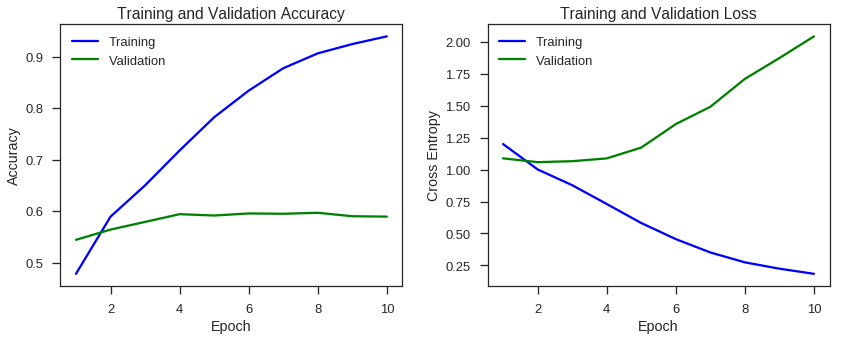

In [49]:
def plot_history(result):
  acc = result.history['acc']
  val_acc = result.history['val_acc']
  loss = result.history['loss']
  val_loss = result.history['val_loss']
  x = range(1, len(acc) + 1)
  plt.figure(figsize=(12, 5))
  # accuracy
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training')
  plt.plot(x, val_acc, 'g', label='Validation')
  plt.title("Training and Validation Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  # loss
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training')
  plt.plot(x, val_loss, 'g', label='Validation')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Cross Entropy")
  plt.legend()
  
  plt.tight_layout()
    
plot_history(result)

## 9. Model Tuning and Evaluation
First, we need to speculate about the layers and nodes in each layer. This is actually heuristic in that there is no clear answer. One thing that can help us guess is VC dimension in which we can theoretically divide all the observations. We have over a hundred thousand of cases and 1,000 features (top words). Three layers with 100 nodes should be enough to describe different cases because these cases tend to be grouped together in practice. In fact, the model found the functions to classify the training set with well over 90% accuracy. In conclusion, we will continue with this architecture to reduce complexity.

Now, our goal is to find the best values for parameters. It seems to be fair that 30 times of epoch is enough. Also, batch size 128 is ideal for using the GPU. Those two can be confirmed on the plot where the loss converges to zero in the smooth line. The biggest problem is overfitting. As seen on the plot, the validation accuracy does not improve as much as the training accuracy. Therefore, the first tuning should be regularization. We may apply two major techniques to solving the issue.

- Regularization term as a parameter in layers
- Dropout layer to turn off some nodes

Along with these added to the model, we will experiment other features such as optimizer and activation functions. This will be done in the grid search manner harnessed with *sklearn* library. To do so, we need to make the model in a function to which we can iterate different values.

In [0]:
from sklearn.model_selection import GridSearchCV

def create_model(input_dim=vocab_size, embedding=50, input_length=vec_size,
                 optimizer='adam', dropout_rate=0.5):
  # sequential model
  model = Sequential()
  
  # input layer
  model.add(layers.Embedding(input_dim=input_dim,
                             output_dim=embedding,
                             input_length=input_length))
  # hidden layer
  model.add(layers.Flatten())
  model.add(layers.Dense(50, activation='sigmoid',
                         kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(50, activation='tanh'))
  model.add(layers.Dropout(dropout_rate))
  model.add(layers.Dense(50, activation='relu'))
  # output layer
  model.add(layers.Dense(5, activation='softmax'))

  # compiling
  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
 
  return model

In [57]:
model = KerasClassifier(build_fn=create_model,
                        epochs=5, batch_size=128, verbose=0)
optimizer = ['Adam', 'Adagrad', 'SGD']
dropout_rate = [0.2, 0.5]

param_grid = dict(optimizer=optimizer, dropout_rate=dropout_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train_nn, y_train_nn)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.552978 using {'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.552978 (0.001638) with: {'dropout_rate': 0.2, 'optimizer': 'Adam'}
0.546814 (0.001876) with: {'dropout_rate': 0.2, 'optimizer': 'Adagrad'}
0.196659 (0.001075) with: {'dropout_rate': 0.2, 'optimizer': 'SGD'}
0.534310 (0.002451) with: {'dropout_rate': 0.5, 'optimizer': 'Adam'}
0.533785 (0.000250) with: {'dropout_rate': 0.5, 'optimizer': 'Adagrad'}
0.197559 (0.001976) with: {'dropout_rate': 0.5, 'optimizer': 'SGD'}


In [60]:
model = create_model(optimizer='adam', dropout_rate=0.2)
result = model.fit(X_train_nn, y_train_nn,
                   epochs=20,
                   verbose=1,
                   validation_data=(X_test_nn, y_test_nn),
                   batch_size=128)

Train on 79976 samples, validate on 19994 samples
Epoch 1/20
79976/79976 [==============================] - 30s 372us/step - loss: 1.3513 - acc: 0.4436 - val_loss: 1.2416 - val_acc: 0.5268
Epoch 2/20
79976/79976 [==============================] - 27s 336us/step - loss: 1.2391 - acc: 0.5348 - val_loss: 1.2262 - val_acc: 0.5466
Epoch 3/20
79976/79976 [==============================] - 27s 339us/step - loss: 1.2178 - acc: 0.5546 - val_loss: 1.2240 - val_acc: 0.5607
Epoch 4/20
79976/79976 [==============================] - 27s 339us/step - loss: 1.2007 - acc: 0.5745 - val_loss: 1.2380 - val_acc: 0.5651
Epoch 5/20
79976/79976 [==============================] - 27s 339us/step - loss: 1.1788 - acc: 0.5941 - val_loss: 1.2483 - val_acc: 0.5713
Epoch 6/20
79976/79976 [==============================] - 27s 338us/step - loss: 1.1532 - acc: 0.6130 - val_loss: 1.2561 - val_acc: 0.5772
Epoch 7/20
79976/79976 [==============================] - 27s 338us/step - loss: 1.1315 - acc: 0.6292 - val_loss: 1.

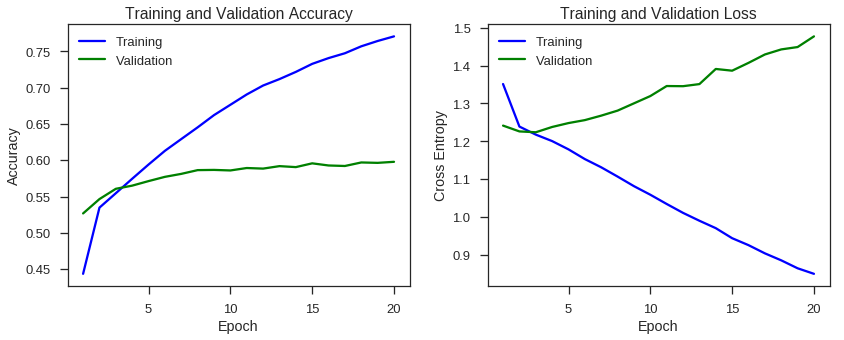

In [61]:
plot_history(result)

## 10. Multiple Input MLP Model
Keras can handle multiple inputs via its functional API which looks a bit different in syntax, but what it does is virtually the same as the sequential API. For the additional input, we will make use of the sentiment analysis. Extracting the sentiments is the same as we did for the sample review, but over all review. Unlike *spacy* did for named entities, this process is much shorter to be done with *Vader*. We will then use the compound scores among others like 'negative' and 'positive' scores because it already has positive and negative information.

In [0]:
X = df[['Text', 'Summary']]
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2
)

sentence_train = X_train['Text']
sentence_test = X_test['Text']

summary_train = X_train['Summary']
summary_test = X_test['Summary']

In [63]:
%%time

# vector size (=top 'n' vectorized tokens)
vec_size = 2000

# tokenizing words in training set
tokenizer = Tokenizer(num_words=vec_size) # length of each sparse array
tokenizer.fit_on_texts(sentence_train) # generate word index

# tfidf representation (train data size X vector length)
sentence_train = tokenizer.texts_to_matrix(sentence_train, mode='tfidf')
sentence_test = tokenizer.texts_to_matrix(sentence_test, mode='tfidf')

summary_train = tokenizer.texts_to_matrix(summary_train, mode='tfidf')
summary_test = tokenizer.texts_to_matrix(summary_test, mode='tfidf')

# [1,2,3,4,5] => [0,1,2,3,4]
y_train_nn = to_categorical(y_train-1)
y_test_nn = to_categorical(y_test-1)

CPU times: user 35 s, sys: 451 ms, total: 35.5 s
Wall time: 35.6 s


For the model architecture, we may just go by hueristic methods with some senses gained from the grid search we have done before. Also, we can do this process with trial and error as does a deep learning model often. This time, we set the epoch 200 times because it seems to continue improving. Also, we have shallow and narrow layers for the numerical feature since sentiment scores are much simpler than vectorized text data.

In [80]:
vocab_size = len(tokenizer.word_index)+1
embedding = 50

input_nlp = layers.Input(shape=(vec_size,))
input_num = layers.Input(shape=(vec_size,))

x = layers.Embedding(input_dim=vocab_size,
                     output_dim=embedding,
                     input_length=vec_size)(input_nlp)
x = layers.Flatten()(x)
x = layers.Dense(50, activation='relu')(input_nlp)
x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(50, activation='relu')(x)
x = keras.Model(inputs=input_nlp, output=x)

y = layers.Embedding(input_dim=vocab_size,
                     output_dim=embedding,
                     input_length=vec_size)(input_num)
y = layers.Flatten()(y)
y = layers.Dense(50, activation='relu')(input_num)
y = layers.Dropout(0.2)(y)
y = layers.Dense(50, activation='tanh')(y)
y = layers.Dropout(0.2)(y)
y = layers.Dense(50, activation='relu')(y)
y = keras.Model(inputs=input_num, output=y)

combined = layers.concatenate([x.output, y.output])

z = layers.Dense(2, activation='linear')(combined)
z = layers.Dense(5, activation='softmax')(z)

model = keras.Model(inputs=[x.input, y.input], output=z)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.01, decay=0.01/30, momentum=0.9))

result = model.fit([sentence_train, summary_train], y_train_nn,
                   validation_data=([sentence_test, summary_test], y_test_nn),
                   epochs=20, batch_size=128)

Train on 79976 samples, validate on 19994 samples
Epoch 1/20
79976/79976 [==============================] - 13s 162us/step - loss: 1.3054 - acc: 0.4102 - val_loss: 1.0456 - val_acc: 0.5450
Epoch 2/20
79976/79976 [==============================] - 8s 100us/step - loss: 1.0201 - acc: 0.5542 - val_loss: 0.9647 - val_acc: 0.5883
Epoch 3/20
79976/79976 [==============================] - 8s 103us/step - loss: 0.9372 - acc: 0.5986 - val_loss: 0.9403 - val_acc: 0.6050
Epoch 4/20
79976/79976 [==============================] - 8s 105us/step - loss: 0.8803 - acc: 0.6265 - val_loss: 0.9275 - val_acc: 0.6158
Epoch 5/20
79976/79976 [==============================] - 9s 107us/step - loss: 0.8327 - acc: 0.6505 - val_loss: 0.9218 - val_acc: 0.6225
Epoch 6/20
79976/79976 [==============================] - 7s 94us/step - loss: 0.7965 - acc: 0.6684 - val_loss: 0.9241 - val_acc: 0.6290
Epoch 7/20
79976/79976 [==============================] - 7s 91us/step - loss: 0.7601 - acc: 0.6857 - val_loss: 0.9319 - v

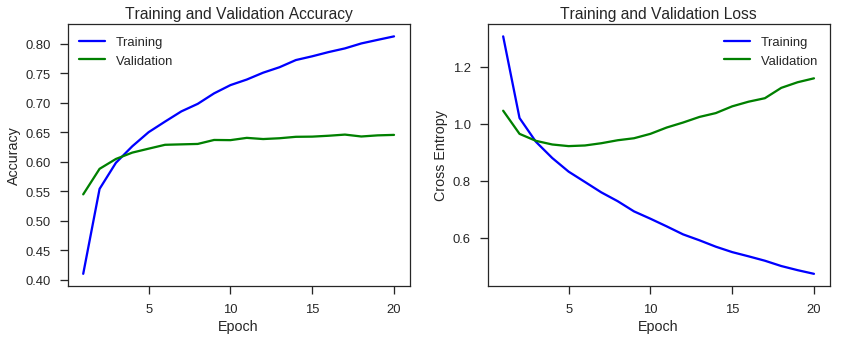

In [81]:
plot_history(result)

In [90]:
np.argmax(pred, axis=1)

array([0, 3, 3, ..., 2, 2, 0])

In [92]:
# [prob1, ..., prob5] => [class]
pred = model.predict([sentence_test, summary_test])
# [0,1,2,3,4] => [1,2,3,4,5]
pred = np.argmax(pred, axis=1) + 1

print("Confusion Matrix")
print(metrics.confusion_matrix(y_test, pred))
print('\n')
print(metrics.classification_report(y_test, pred))
print("Accuracy:", round(metrics.accuracy_score(y_test, pred), 2))
print('\n')

Confusion Matrix
[[3024  708  190   67   78]
 [ 643 2417  665  148   63]
 [ 206  659 2397  540  145]
 [ 101  116  622 2212  948]
 [  91   56  184  851 2863]]


              precision    recall  f1-score   support

           1       0.74      0.74      0.74      4067
           2       0.61      0.61      0.61      3936
           3       0.59      0.61      0.60      3947
           4       0.58      0.55      0.57      3999
           5       0.70      0.71      0.70      4045

   micro avg       0.65      0.65      0.65     19994
   macro avg       0.64      0.65      0.64     19994
weighted avg       0.65      0.65      0.65     19994

Accuracy: 0.65




## 11. Conclusion and Reference

In this project, we explored review data in diverse respects. Statistical analysis found that reviews with lower scores used less adjectives and adverbs. Based on this, we could lead to the topic analysis where we confirmed that all the reviews are very straightforward and all related to foods. As we found it out earlier, the scores were so skewed that we applied an undersampling method to balance out the classes. We then converted text data into tfidf vectors in which machine can read in order to train a model. Modeling was done by three different manners; logistic regression, deep learning, multiple input deep learning. After realizing that a deep learning model is better than the baseline model, we advanced the deep learning model to the multiple input version. The additional feature was the sentiments scores in numeriacl type. 

**Dataset**
- [Dataset from Kaggel](https://www.kaggle.com/snap/amazon-fine-food-reviews/version/2)

<br>
**Techniques**
- [Word2Vec embedding tutorial](https://youtu.be/64qSgA66P-8)
- [Regularization on layers](https://stackoverflow.com/questions/29653321/add-column-to-tfidf-matrix)

<br>
**Keras Syntax**
- [Text preprocessing in Keras](https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/)
- [Keras text classification tutorial](https://realpython.com/python-keras-text-classification/)
- [Keras and sklearn GridSearch](https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/)
- [Multiple input to Keras MLP](https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/)

<br>
**Other Libraries**
- [Imblearn undersampling](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling)
- [Spacy NER](https://spacy.io/usage/processing-pipelines)